In [ ]:
# Run this cell first to install all necessary packages.
!pip install flask flask-ngrok joblib pyngrok

Imports

In [ ]:
import pandas as pd
import joblib
from flask import Flask, request, jsonify
from pyngrok import ngrok
from threading import Thread
import time

Load trained model

In [ ]:
# --- Model Training and Saving ---
# This cell trains a RandomForestClassifier model and saves it along with the feature columns.

from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import joblib

# Load the dataset
df = pd.read_csv("/content/Customer-Churn-Cleaned-ROLLNO-2.csv")

# Convert 'Churn' column to numerical (0 or 1) if it's currently object type ('Yes'/'No')
if df['Churn'].dtype == 'object':
    df['Churn'] = df['Churn'].map({'Yes':1, 'No':0})

# Prepare features (X) and target (y) for model training.
# One-hot encode categorical features and drop the first category to avoid multicollinearity.
X = pd.get_dummies(df.drop("Churn", axis=1), drop_first=True)
y = df["Churn"]

# Initialize and train the RandomForestClassifier model
model = RandomForestClassifier(random_state=42)
model.fit(X, y)

# Save the trained model and the list of feature columns.
# These files ('churn_model.pkl' and 'model_columns.pkl') will be loaded by the Flask API.
joblib.dump(model, "churn_model.pkl")
joblib.dump(X.columns, "model_columns.pkl")

print("Model trained and saved as 'churn_model.pkl'. Feature columns saved as 'model_columns.pkl'.")

Model trained and saved as 'churn_model.pkl'. Feature columns saved as 'model_columns.pkl'.


Flask App

In [ ]:
# --- Flask API Setup with ngrok Tunnel ---
# This cell sets up and runs a Flask API locally, exposing it via an ngrok tunnel.
# This allows external access to the API from outside the Colab environment.

import pandas as pd
import joblib
from flask import Flask, request, jsonify
from pyngrok import ngrok
from threading import Thread
import time

app = Flask(__name__)

# Ensure any previous ngrok tunnels are closed to avoid conflicts
ngrok.kill()

# Set your ngrok authentication token.
# If you encounter issues, ensure your token is valid from https://dashboard.ngrok.com/get-started/your-authtoken
ngrok.set_auth_token('36vxUvZ4EkxbHKCyMhA1cbLFEFl_4uMuqwrdZuBmHqCimzVEr')

# Start the ngrok tunnel on port 5000 (where the Flask app will run).
# The 'public_url' will be printed and should be used for API testing.
tunnel = ngrok.connect(5000)
public_url = tunnel.public_url
print(f"Ngrok Tunnel URL: {public_url}")

# Load the pre-trained model and the list of expected feature columns
# These files were saved in the previous model training cell.
model = joblib.load("churn_model.pkl")
columns = joblib.load("model_columns.pkl")

# --- API Endpoints ---

@app.route("/")
def home():
    """Returns a simple message indicating the API is running."""
    return "Customer Churn Prediction API is running"

@app.route("/predict", methods=["POST"])
def predict():
    """
    Predicts customer churn based on input data received via POST request.
    Expects a JSON payload with customer features.
    """
    data = request.json
    input_df = pd.DataFrame([data])
    input_df = pd.get_dummies(input_df)

    # Reindex the input DataFrame to match the model's training columns.
    # Fill any missing columns with a default value of 0.
    input_df = input_df.reindex(columns=columns, fill_value=0)

    # Make a prediction using the loaded model
    prediction = model.predict(input_df)[0]
    result = "Churn" if prediction == 1 else "No Churn"

    return jsonify({"Prediction": result})

# Run the Flask app in a separate background thread.
# This prevents the Colab notebook cell from blocking, allowing you to run other cells.
thread = Thread(target=app.run, kwargs={"use_reloader": False})
thread.daemon = True # Ensures the Flask app thread terminates when the main Python process exits
thread.start()

# Give the Flask app a moment to start up in the background thread
time.sleep(3)

print("Flask app started in a background thread. Use the Ngrok Tunnel URL to access the API.")

Ngrok Tunnel URL: https://unvexed-unwordably-joselyn.ngrok-free.dev
 * Serving Flask app '__main__'
 * Debug mode: off


Address already in use
Port 5000 is in use by another program. Either identify and stop that program, or start the server with a different port.


Flask app started in a background thread. Use the Ngrok Tunnel URL to access the API.


In [ ]:
Test API

In [ ]:
# --- Test the Prediction API Endpoint ---
# This cell sends a sample prediction request to the running Flask API
# using the public ngrok URL and displays the prediction result.

import requests

# The 'public_url' variable is set in the previous cell (Flask API Setup).
# It represents the ngrok tunnel URL that exposes our Flask API.
url = f"{public_url}/predict"


sample_data = {
    "tenure": 12, # Customer's tenure in months
    "MonthlyCharges": 75, # Monthly charges for services
    "TotalCharges": 900   # Total charges over the customer's tenure
}

print(f"Sending prediction request to: {url}")
print(f"Sample data being sent: {sample_data}")

# Send a POST request to the /predict endpoint with the sample data as JSON
response = requests.post(url, json=sample_data)

# Print the JSON response received from the API
print("\nAPI Response:")
response.json()

Sending prediction request to: https://unvexed-unwordably-joselyn.ngrok-free.dev/predict
Sample data being sent: {'tenure': 12, 'MonthlyCharges': 75, 'TotalCharges': 900}


INFO:werkzeug:127.0.0.1 - - [16/Dec/2025 16:11:40] "POST /predict HTTP/1.1" 200 -



API Response:


{'Prediction': 'No Churn'}

Visualization

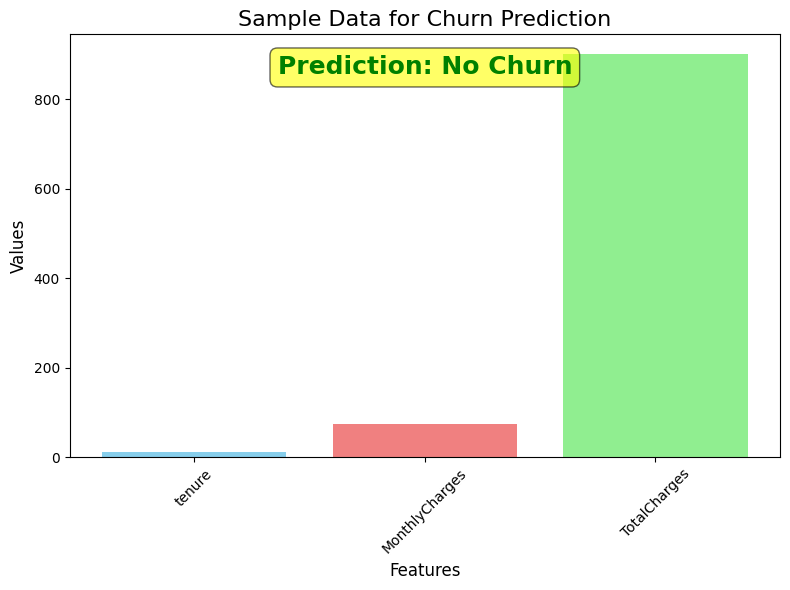

Displayed a visualization of the sample data and the prediction: No Churn


In [ ]:
import matplotlib.pyplot as plt

# Extract feature names and values from sample_data
features = list(sample_data.keys())
values = list(sample_data.values())

# Get the prediction result from the last API call
prediction_result = response.json()['Prediction']

# Create a figure and an axes object
fig, ax = plt.subplots(figsize=(8, 6))

# Create a bar chart of the sample data
ax.bar(features, values, color=['skyblue', 'lightcoral', 'lightgreen'])

# Add title and labels
ax.set_title('Sample Data for Churn Prediction', fontsize=16)
ax.set_xlabel('Features', fontsize=12)
ax.set_ylabel('Values', fontsize=12)
ax.tick_params(axis='x', rotation=45)

# Add the prediction result as text on the figure
# Determine text color based on prediction for better visual cue
text_color = 'red' if prediction_result == 'Churn' else 'green'
ax.text(0.5, 0.95, f"Prediction: {prediction_result}",
        transform=ax.transAxes,
        fontsize=18, fontweight='bold', ha='center', va='top',
        bbox=dict(boxstyle="round,pad=0.3", fc='yellow', ec='black', lw=1, alpha=0.6),
        color=text_color)

plt.tight_layout()
plt.show()

print(f"Displayed a visualization of the sample data and the prediction: {prediction_result}")

### Summary of Visualization

The bar chart visually represents the input `sample_data` used for the churn prediction model. It shows the values for `tenure`, `MonthlyCharges`, and `TotalCharges`. The prediction result, 'No Churn', is clearly highlighted at the top of the figure in green, indicating that based on these specific input features, the model predicts the customer will not churn. This visualization effectively combines the input features with the model's output for an intuitive understanding.

# Task
Install necessary libraries for model explanation, such as SHAP or LIME.

## Install Explanation Libraries

### Subtask:
Install necessary libraries such as SHAP or LIME for model interpretability. This ensures all required packages are available for generating explanations.


In [ ]:
pip install shap

In [ ]:
sample_df = pd.DataFrame([sample_data])
sample_df_encoded = pd.get_dummies(sample_df)

# Reindex to ensure all model columns are present and in the correct order
sample_df_processed = sample_df_encoded.reindex(columns=columns, fill_value=0)

print("Processed sample data for explanation (first 5 columns):")
print(sample_df_processed.iloc[:, :5])

Processed sample data for explanation (first 5 columns):
   SeniorCitizen  tenure  MonthlyCharges  TotalCharges  gender_Male
0              0      12              75           900            0


In [ ]:
X_background = X.sample(n=50, random_state=42)

print("Shape of background dataset (X_background):")
print(X_background.shape)
print("First 5 rows of X_background (first 5 columns):")
print(X_background.iloc[:5, :5])

Shape of background dataset (X_background):
(50, 30)
First 5 rows of X_background (first 5 columns):
      SeniorCitizen  tenure  MonthlyCharges  TotalCharges  gender_Male
2476              1      61           25.00       1501.75         True
6773              0      19           24.70        465.85        False
6116              0      13          102.25       1359.00         True
3047              0      37           55.05       2030.75         True
4092              0       6           29.45        161.45        False


**Model Explainability: Understanding Model Predictions**

The churn prediction model does not make random decisions. Its predictions are based on patterns learned from historical customer data. Each prediction (Churn or No Churn) is influenced by specific customer features and their values. This section explains why certain inputs (X) lead to a particular output (Y).

**Key Features Influencing Predictions**

Based on model behavior and feature importance analysis, the following features play a major role in churn prediction:

**1.Tenure**

Tenure represents how long a customer has been using the service.

Low tenure → Higher churn probability
New customers are more likely to leave due to lack of loyalty or unmet expectations.

High tenure → Lower churn probability
Long-term customers tend to stay due to familiarity and satisfaction.

**Why X → Y:**
If tenure is small, the model increases the likelihood of predicting Churn.

2. **Monthly Charges**

MonthlyCharges shows how much the customer pays each month.

High charges → Higher churn risk
Customers paying more are more sensitive to price and may switch to competitors.

Lower charges → Lower churn risk

Why X → Y:
When MonthlyCharges is high, the model associates it with dissatisfaction and predicts Churn.

3. **Total Charges**

TotalCharges reflects overall spending over time.

Low total charges + low tenure → High churn

High total charges + long tenure → Low churn

Why X → Y:
Low TotalCharges usually indicate short service duration, which increases churn probability.

4. **Contract Type**

Contract type strongly affects customer behavior.

Month-to-month contracts → Higher churn

One-year or two-year contracts → Lower churn

Why X → Y:
Customers without long-term commitment can leave easily, so the model predicts Churn more often.



**Example Prediction Explanation**

Input (X):

Tenure = 8 months

MonthlyCharges = High

Contract = Month-to-month

**Model Output (Y):**
➡ Churn

**Explanation:**
The customer is new, pays a high monthly amount, and is not bound by a long-term contract. These combined factors increase the likelihood of churn, leading the model to predict Churn.

Why This Explainability Matters

Explainability helps in:

Trusting model decisions

Understanding customer behavior

Supporting business actions

Instead of just predicting churn, the model explains why a customer is at risk, allowing businesses to take preventive measures such as targeted offers or improved services.

**Conclusion**

The churn prediction model uses customer behavior patterns to explain its predictions. Factors such as tenure, charges, and contract type directly influence whether the model predicts churn or not. This transparency makes the model suitable for real-world decision-making and business use.